# Code for testing the vignette pipeline #

### Step 1: Setup ###

In [1]:
import os
import sys
import json
from pathlib import Path
import open3d as o3d
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# get the root for importing test data
os.environ["SAM_BACKEND"] = "coreml"
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import pipeline modules
from pipeline import segmentation, pointcloud

scikit-learn version 1.7.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.5.1. Disabling scikit-learn conversion API.
Torch version 2.8.0 has not been tested with coremltools. You may run into unexpected errors. Torch 2.5.0 is the most recent version that has been tested.


In [3]:
# Configuration
VIGNETTE_NAME = "capture2"
VIGNETTE_PATH = project_root / "test_data" / VIGNETTE_NAME
print(f"Project Root: {project_root}")
print(f"Testing Vignette: {VIGNETTE_PATH}")

Project Root: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer
Testing Vignette: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2


In [4]:
# Paths for the inputs and outputs
rgb_path = VIGNETTE_PATH / "rgb.png"
metadata_path = VIGNETTE_PATH / "metadata.json"
results_path = VIGNETTE_PATH / "results"

In [5]:
# Open3d display helper
def display_geometries(geometries: list, window_name: str = "Open3D"):
    # Create a Visualizer object
    vis = o3d.visualization.Visualizer()
    # Create the window with a custom name
    vis.create_window(window_name=window_name)
    # Add each geometry to the visualizer
    for geometry in geometries:
        vis.add_geometry(geometry)  
    # Run the visualizer
    vis.run()
    # Destroy it after close
    vis.destroy_window()
    vis.close()
    del vis

### Step 2: SAM Segmentation ###

In [9]:
# UV for testing
uv_coords = [0.5, 0.5]

# Run SAM to get raw logits
logits_path = segmentation.generate_sam_logits(
    rgb_image_path=rgb_path,
    uv_coords=uv_coords,
    output_path=results_path
)
print(f"Logits generated and saved to: {logits_path}")

[sam2] Loading CoreML SAM2 models…
[sam2] Saved CoreML SAM2 logits: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/mask_logits.npy shape=(1440, 1920)
Logits generated and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/mask_logits.npy


[sam] Wrote mask: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/mask.png
Mask created and saved to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/mask.png


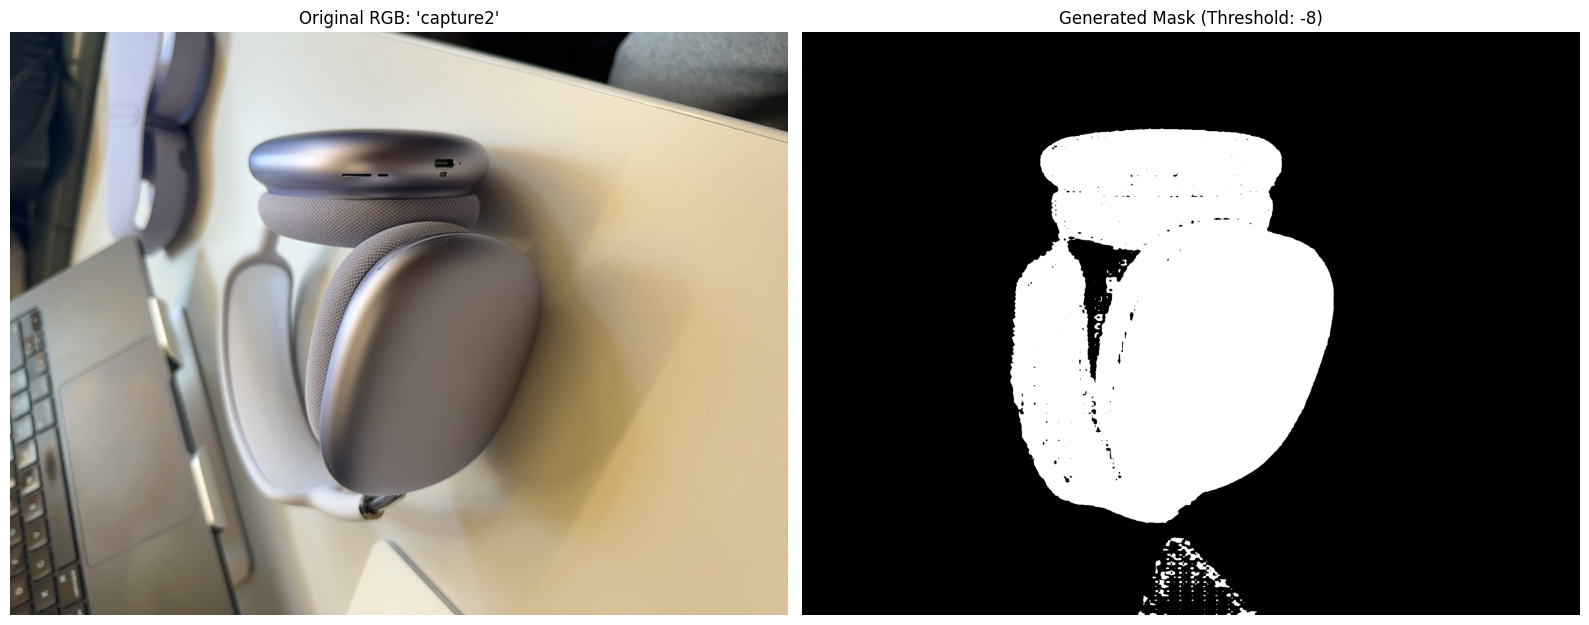

In [18]:
sam_threshold = -8
# Apply the threshold
mask_path = segmentation.apply_threshold_to_logits(
    logits_path=logits_path,
    threshold=sam_threshold,
    output_path=results_path
)
print(f"Mask created and saved to: {mask_path}")

# Display
rgb_image = Image.open(rgb_path)
mask_image = Image.open(mask_path)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(rgb_image)
axes[0].set_title(f"Original RGB: '{VIGNETTE_NAME}'")
axes[0].axis('off')

axes[1].imshow(mask_image, cmap='gray')
axes[1].set_title(f"Generated Mask (Threshold: {sam_threshold})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Step 3: Generate Point Cloud ###

In [6]:
# get point cloud
vignette_path = pointcloud.create_masked_point_cloud(VIGNETTE_PATH)

Processing point cloud for: capture2
Generated and centered point cloud with 10312 points.
Set/updated per-point attribute: 'confidence'.
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/raw_vignette.npz


In [8]:
vignette_path = results_path / "raw_vignette.npz"
 
# Load the points as a processed vignette
from pipeline.vignette_data import ProcessedVignette
raw_vignette = ProcessedVignette.load(vignette_path)

Set/updated per-point attribute: 'confidence'.
Saved processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/raw_vignette.npz


In [21]:
# Visualize Colors
pcd_rgb = raw_vignette.to_open3d(color_mode="rgb")
display_geometries([pcd_rgb], window_name="Vignette (RGB Colors)")

Generating Open3D point cloud with 'rgb' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [9]:
# Visualize Confidence
pcd_confidence = raw_vignette.to_open3d(color_mode="confidence")
display_geometries([pcd_confidence], window_name="Vignette (Confidence Colors)")

Generating Open3D point cloud with 'confidence' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


### Step 4: Preprocess Point Cloud ###

In [9]:
from pipeline import preprocessing

processed_vignette = preprocessing.preprocess_vignette(
    raw_vignette=raw_vignette,
    confidence_threshold=1,
    voxel_size=0.001,
    sor_std_ratio=3.0
)

# save it
processed_vignette_path = results_path / "processed_vignette.npz"
processed_vignette.save(processed_vignette_path)

--- Starting Preprocessing ---
Initial points: 10312
Filtering points with confidence < 1...
Points after confidence filtering: 9118
Downsampling with voxel size: 0.001...
Points after downsampling: 9017
Removing statistical outliers...
Points after outlier removal: 8971
Estimating normals...
Normals estimated and oriented.
Reconciling custom attributes...
Reconciled 1 custom attributes.
Set/updated per-point attribute: 'confidence'.
--- Preprocessing complete. Returning new clean vignette. ---
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz


Generating Open3D point cloud with 'rgb' colors...
Generating Open3D point cloud with 'rgb' colors...


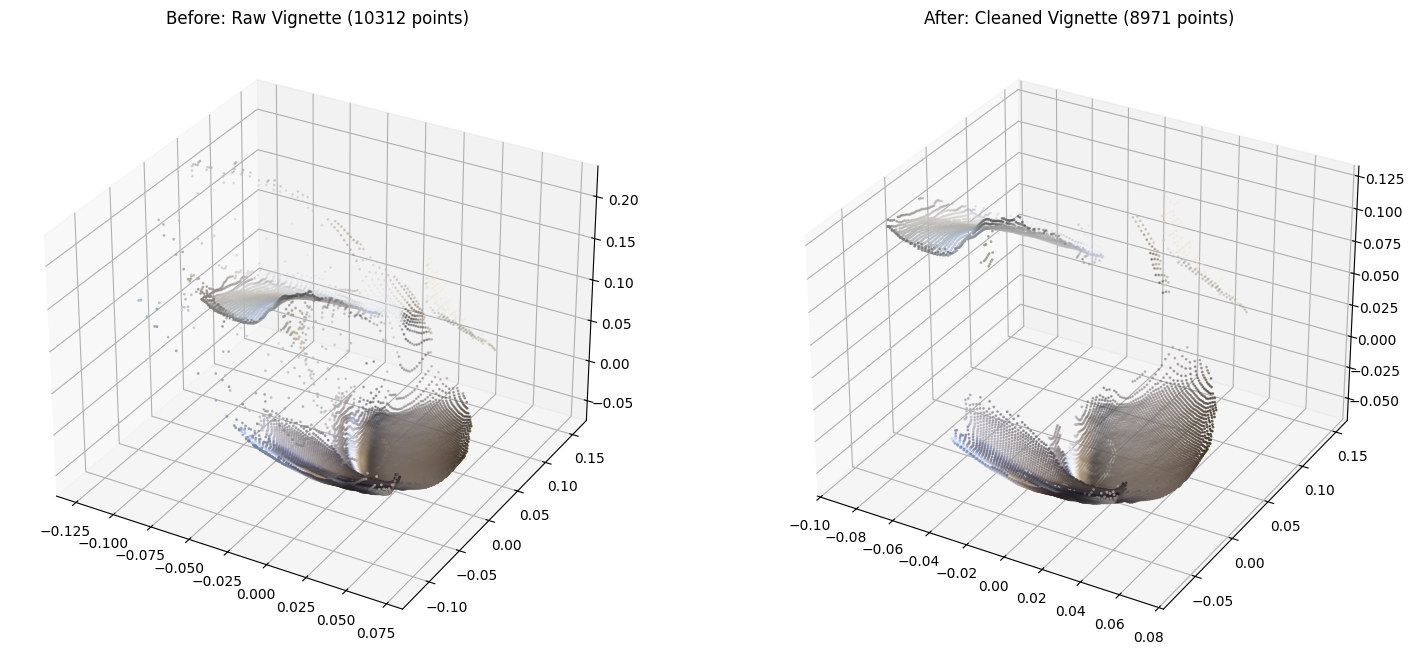

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(18, 8))

# Before
ax1 = fig.add_subplot(121, projection='3d')
pcd_raw_viz = raw_vignette.to_open3d().voxel_down_sample(0.001) # Downsample for viz
ax1.scatter(
    np.asarray(pcd_raw_viz.points)[:, 0], np.asarray(pcd_raw_viz.points)[:, 1], np.asarray(pcd_raw_viz.points)[:, 2],
    c=np.asarray(pcd_raw_viz.colors), s=1
)
ax1.set_title(f"Before: Raw Vignette ({len(raw_vignette.points)} points)")
    
# After
ax2 = fig.add_subplot(122, projection='3d')
pcd_clean_viz = processed_vignette.to_open3d()
ax2.scatter(
    np.asarray(pcd_clean_viz.points)[:, 0], np.asarray(pcd_clean_viz.points)[:, 1], np.asarray(pcd_clean_viz.points)[:, 2],
    c=np.asarray(pcd_clean_viz.colors), s=1
)
ax2.set_title(f"After: Cleaned Vignette ({len(processed_vignette.points)} points)")
    
plt.show()

In [24]:
pcd = processed_vignette.to_open3d()
display_geometries([pcd], window_name="Preprocessed Vignette")

Generating Open3D point cloud with 'rgb' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


### Step 5: Abstraction ###

In [11]:
from pipeline import abstraction

# Load preprocessed vignette for tests
processed_vignette_path = results_path / "processed_vignette.npz"
from pipeline.vignette_data import ProcessedVignette
processed_vignette = ProcessedVignette.load(processed_vignette_path)

Set/updated per-point attribute: 'confidence'.
Saved processed vignette from: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz


In [8]:
# Save vignette!
processed_vignette.save()

Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz


In [26]:
# 01 Dominant Axes
abstraction.extract_dominant_axes(
    processed_vignette,
    cluster_eps=0.04,
    min_cluster_points=50
)
processed_vignette.save()

Extracting dominant axes...
   - Analyzing global axis...
Added new abstraction of type 'axes'.
   - Global axis found with extent: [0.21 0.22 0.09]
   - Clustering components with eps=0.04...
Set/updated per-point attribute: 'component_id'.
   - Found 1 components.
Added new abstraction of type 'axes'.
Finished extracting dominant axes.
Saved processed vignette to: /Users/yuzhenzhang/Documents/Research/TestApp/SpatialVignetteServer/test_data/capture2/results/processed_vignette.npz


In [27]:
# Visualize
pcd_colored_by_component = processed_vignette.to_open3d(color_mode='component_id')
axes_abstractions = processed_vignette.get_abstractions('axes')

'''
print("--- Contents of 'axes' Abstraction ---")
if axes_abstractions:
    # Pretty-print the JSON-like data stored in the metadata
    print(json.dumps(axes_abstractions, indent=2))
else:
    print("No 'axes' abstractions were found in the vignette's metadata.")
    '''

geometries_to_draw = [pcd_colored_by_component]

line_set_points = []
line_set_lines = []
line_set_colors = []
point_index_counter = 0

if axes_abstractions:
    print(f"\nFound {len(axes_abstractions)} axes to visualize.")
    for axis_info in axes_abstractions:
        center = np.array(axis_info['center'])
        
        # --- a) Reconstruct the Bounding Boxes (OBBs) ---
        obb = o3d.geometry.OrientedBoundingBox(
            center=center,
            R=np.array(axis_info['axes']).T,
            extent=axis_info['extent']
        )
        if axis_info.get('type') == 'global':
            obb.color = (1, 0, 0)  # Red
        else:
            obb.color = (0, 1, 0)  # Green
        geometries_to_draw.append(obb)

        # --- b) Build the Axis Lines for the LineSet ---
        axes = axis_info['axes']
        extents = axis_info['extent']
        primary_axis = np.array(axis_info['primary_axis'])

        for i in range(3):
            axis_vector = np.array(axes[i])
            half_extent = extents[i] / 2.0
            
            # Calculate the start and end points of the line segment for this axis
            start_point = center - axis_vector * half_extent
            end_point = center + axis_vector * half_extent
            
            # Add the two points to our list of vertices
            line_set_points.append(start_point)
            line_set_points.append(end_point)
            
            # Add the line connection (connecting the last two points we added)
            line_set_lines.append([point_index_counter, point_index_counter + 1])
            point_index_counter += 2
            
            # Color the primary axis magenta and the others cyan
            if np.allclose(axis_vector, primary_axis):
                line_set_colors.append([1, 0, 1]) # Magenta
            else:
                line_set_colors.append([0, 1, 1]) # Cyan

# Create the LineSet object if we have lines to draw
if line_set_points:
    axis_lines = o3d.geometry.LineSet()
    axis_lines.points = o3d.utility.Vector3dVector(line_set_points)
    axis_lines.lines = o3d.utility.Vector2iVector(line_set_lines)
    # The LineSet requires a color for each line, not each point
    axis_lines.colors = o3d.utility.Vector3dVector(line_set_colors)
    geometries_to_draw.append(axis_lines)


# --- Step 3: Visualize Everything Together ---

print("\nDisplaying point cloud, OBBs (green), and axis lines (magenta/cyan)...")
display_geometries(geometries_to_draw, window_name="Dominant Axes")

Generating Open3D point cloud with 'component_id' colors...

Found 2 axes to visualize.

Displaying point cloud, OBBs (green), and axis lines (magenta/cyan)...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [ ]:
# do everything
abstraction.extract_dominant_planes(
    processed_vignette,
    distance_threshold=0.003,
    min_points_per_plane=300
)
abstraction.extract_dominant_cylinders(
    processed_vignette,
    distance_threshold=0.01,
    min_points_per_cylinder=200
)
abstraction.extract_dominant_spheres(
    processed_vignette,
    distance_threshold=0.002,
    min_points_per_sphere=200
)
abstraction.extract_dominant_cuboids(
    processed_vignette,
    distance_threshold=0.008,
    min_points_per_cuboid=500
)

In [7]:
print("--- Running Plane Extraction and Visualization ---")

# 1. Call the abstraction function
abstraction.extract_dominant_planes(
    processed_vignette,
    distance_threshold=0.003,
    min_points_per_plane=300
)

# 2. Prepare geometries for visualization
pcd_planes = processed_vignette.to_open3d(color_mode='plane_id')
plane_abstractions = processed_vignette.get_abstractions('planes')
plane_geometries = [pcd_planes]
cmap_accent = cm.get_cmap("Accent")

if plane_abstractions:
    for i, plane_info in enumerate(plane_abstractions):
        if "obb_center" not in plane_info: continue
        
        # Reconstruct the rectangular mesh from the stored OBB properties
        center, rotation, extent = np.array(plane_info['obb_center']), np.array(plane_info['obb_rotation']), np.array(plane_info['obb_extent'])
        axes = [rotation[:, 0], rotation[:, 1], rotation[:, 2]]
        sorted_indices = np.argsort(extent)
        major_axis, minor_axis = axes[sorted_indices[2]], axes[sorted_indices[1]]
        major_half, minor_half = extent[sorted_indices[2]] / 2.0, extent[sorted_indices[1]] / 2.0

        v1 = center + major_axis * major_half + minor_axis * minor_half
        v2 = center - major_axis * major_half + minor_axis * minor_half
        v3 = center - major_axis * major_half - minor_axis * minor_half
        v4 = center + major_axis * major_half - minor_axis * minor_half
        
        vertices = o3d.utility.Vector3dVector([v1, v2, v3, v4])
        triangles = o3d.utility.Vector3iVector([[0, 1, 2], [0, 2, 3], [0, 2, 1], [0, 3, 2]])
        plane_mesh = o3d.geometry.TriangleMesh(vertices, triangles)
        plane_mesh.compute_vertex_normals()
        plane_mesh.paint_uniform_color(cmap_accent(i / len(plane_abstractions))[:3])
        plane_geometries.append(plane_mesh)

# 3. Display the result
display_geometries(plane_geometries, "Dominant Planes Abstraction")

--- Running Plane Extraction and Visualization ---
Extracting dominant planes...
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Added new abstraction of type 'planes'.
Set/updated per-point attribute: 'plane_id'.
Finished extracting dominant planes.
Generating Open3D point cloud with 'plane_id' colors...


/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_3343/2024092760.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [8]:
print("--- Running Cylinder Extraction and Visualization ---")

# 1. Call the abstraction function
abstraction.extract_dominant_cylinders(
    processed_vignette,
    distance_threshold=0.01,
    min_points_per_cylinder=200
)

# 2. Prepare geometries for visualization
pcd_cylinders = processed_vignette.to_open3d(color_mode='cylinder_id')
cylinder_abstractions = processed_vignette.get_abstractions('cylinders')
cylinder_geometries = [pcd_cylinders]
cmap_accent = cm.get_cmap("Accent")

if cylinder_abstractions:
    for i, cyl_info in enumerate(cylinder_abstractions):
        # Get the primitive's parameters from the metadata.
        # RANSAC gives a point on the infinite axis, not necessarily the segment center.
        ransac_center = np.array(cyl_info['center'])
        axis = np.array(cyl_info['axis'])
        radius = cyl_info['radius']

        # Get the actual points that belong to this cylinder to find its true bounds.
        inlier_points = processed_vignette.points[cyl_info['point_indices']]
        
        # Project the inlier points onto the cylinder's axis to find the segment's height and center.
        projections = np.dot(inlier_points - ransac_center, axis)
        min_proj, max_proj = np.min(projections), np.max(projections)
        height = max_proj - min_proj
        
        # The true center of the finite cylinder segment is the midpoint of the projections.
        segment_center = ransac_center + axis * ((min_proj + max_proj) / 2.0)
        
        # Create a mesh with the calculated height.
        cylinder_mesh = o3d.geometry.TriangleMesh.create_cylinder(radius=radius, height=height, resolution=20)
        
        # Robustly calculate the rotation to align the mesh with the cylinder's axis.
        z_axis = np.array([0., 0., 1.])
        axis_norm = axis / np.linalg.norm(axis)
        
        if np.allclose(z_axis, axis_norm):
            rotation_matrix = np.identity(3)
        elif np.allclose(z_axis, -axis_norm):
            rotation_matrix = cylinder_mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
        else:
            rotation_vector = np.cross(z_axis, axis_norm) * np.arccos(np.clip(np.dot(z_axis, axis_norm), -1.0, 1.0))
            rotation_matrix = cylinder_mesh.get_rotation_matrix_from_axis_angle(rotation_vector)
            
        cylinder_mesh.rotate(rotation_matrix, center=[0,0,0])
        
        # Translate to the calculated center of the bounded segment.
        cylinder_mesh.translate(segment_center)

        cylinder_mesh.paint_uniform_color(cmap_accent(i / len(cylinder_abstractions))[:3])
        cylinder_geometries.append(cylinder_mesh)

# 3. Display the result
display_geometries(cylinder_geometries, "Dominant Cylinders Abstraction")


--- Running Cylinder Extraction and Visualization ---
Extracting dominant cylinders...
Added new abstraction of type 'cylinders'.
Added new abstraction of type 'cylinders'.
Added new abstraction of type 'cylinders'.
Set/updated per-point attribute: 'cylinder_id'.
Finished extracting dominant cylinders.
Generating Open3D point cloud with 'cylinder_id' colors...


/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_3343/1752661632.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [9]:
print("--- Running Sphere Extraction and Visualization ---")

# 1. Call the abstraction function
abstraction.extract_dominant_spheres(
    processed_vignette,
    distance_threshold=0.002,
    min_points_per_sphere=200
)

# 2. Prepare geometries for visualization
pcd_spheres = processed_vignette.to_open3d(color_mode='sphere_id')
sphere_abstractions = processed_vignette.get_abstractions('spheres')
sphere_geometries = [pcd_spheres]
cmap_accent = cm.get_cmap("Accent")

if sphere_abstractions:
    for i, sphere_info in enumerate(sphere_abstractions):
        # For spheres, the RANSAC result is already bounded. We can visualize it directly.
        # The OBB is still useful for analysis but not required for simple visualization.
        center = np.array(sphere_info['center'])
        radius = sphere_info['radius']
        
        sphere_mesh = o3d.geometry.TriangleMesh.create_sphere(radius=radius, resolution=20)
        sphere_mesh.translate(center)
        sphere_mesh.paint_uniform_color(cmap_accent(i / len(sphere_abstractions))[:3])
        sphere_geometries.append(sphere_mesh)

# 3. Display the result
display_geometries(sphere_geometries, "Dominant Spheres Abstraction")

--- Running Sphere Extraction and Visualization ---
Extracting dominant spheres...
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Added new abstraction of type 'spheres'.
Set/updated per-point attribute: 'sphere_id'.
Finished extracting dominant spheres.
Generating Open3D point cloud with 'sphere_id' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_3343/3872829601.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


In [7]:
print("\n--- Running Cuboid Extraction and Visualization ---")

# 1. Call the abstraction function
abstraction.extract_dominant_cuboids(
    processed_vignette,
    distance_threshold=0.008,
    min_points_per_cuboid=500
)

# 2. Prepare geometries for visualization
pcd_cuboids = processed_vignette.to_open3d(color_mode='cuboid_id')
cuboid_abstractions = processed_vignette.get_abstractions('cuboids')
cuboid_geometries = [pcd_cuboids]
cmap_accent = cm.get_cmap("Accent")

if cuboid_abstractions:
    for i, cuboid_info in enumerate(cuboid_abstractions):
        # pyransac3d's cuboid result is already an OBB, which we store directly.
        center = np.array(cuboid_info['obb_center'])
        rotation = np.array(cuboid_info['obb_rotation'])
        extent = np.array(cuboid_info['obb_extent'])

        # Reconstruct the Open3D OBB object
        obb = o3d.geometry.OrientedBoundingBox(center, rotation, extent)
        
        # Create a mesh from the OBB for visualization
        cuboid_mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obb)
        
        cuboid_mesh.compute_vertex_normals()
        cuboid_mesh.paint_uniform_color(cmap_accent(i / len(cuboid_abstractions))[:3])
        cuboid_geometries.append(cuboid_mesh)
        
# 3. Display the result
display_geometries(cuboid_geometries, "Dominant Cuboids Abstraction")


--- Running Cuboid Extraction and Visualization ---
Extracting dominant cuboids...
Cleared 3 abstractions of type 'cuboids'.
Added new abstraction of type 'cuboids'.
Added new abstraction of type 'cuboids'.
Added new abstraction of type 'cuboids'.
Set/updated per-point attribute: 'cuboid_id'.
Finished extracting dominant cuboids.
Generating Open3D point cloud with 'cuboid_id' colors...
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_3671/932242064.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


In [9]:
abstraction.compose_best_fit_abstraction(
    processed_vignette,
    0.01
)

Composing best-fit abstraction...
   - Starting greedy selection. A primitive must explain at least 89 new points.

   - Evaluating Candidate #1: cuboids (ID: 2, Score: 74728902.44)
     - Point Count: 2133, Fit Error: 0.0000
     - It has 2133 total points. Of those, 2133 are currently unexplained.
     - ACCEPTED: 2133 >= threshold 89.

   - Evaluating Candidate #2: spheres (ID: 1, Score: 4581005.80)
     - Point Count: 3691, Fit Error: 0.0008
     - It has 3691 total points. Of those, 3385 are currently unexplained.
     - ACCEPTED: 3385 >= threshold 89.

   - Evaluating Candidate #3: cuboids (ID: 1, Score: 2906128.11)
     - Point Count: 6059, Fit Error: 0.0021
     - It has 6059 total points. Of those, 2715 are currently unexplained.
     - ACCEPTED: 2715 >= threshold 89.

   - Evaluating Candidate #4: spheres (ID: 2, Score: 2145601.66)
     - Point Count: 1613, Fit Error: 0.0008
     - It has 1613 total points. Of those, 92 are currently unexplained.
     - ACCEPTED: 92 >= thresh

In [12]:


print("\n--- Visualizing Best-Fit Composition ---")

# 1. Prepare the main point cloud, colored by the new 'best_fit_id'
pcd_best_fit = processed_vignette.to_open3d(color_mode='best_fit_id')
geometries_to_draw = [pcd_best_fit]

# 2. Get the final list of selected primitives from the metadata
final_composition = processed_vignette.metadata.get('best_fit_composition')
cmap_accent = cm.get_cmap("Accent")

# --- NEW: Debugging Insights Section ---
print("\n--- Best-Fit Composition Analysis ---")
all_candidates = []
candidate_abstractions = processed_vignette.get_abstractions() or {}
for primitive_type, primitives in candidate_abstractions.items():
    # We only care about the primitive types that compose_best_fit looks at
    if primitive_type not in ['planes', 'cylinders', 'spheres', 'cuboids']:
        continue
    for primitive in primitives:
        all_candidates.append({
            "type": primitive_type,
            "id": primitive.get(f"{primitive_type[:-1]}_id"), # e.g., plane_id
            "score": primitive.get('point_count', 0)
        })

if not all_candidates:
    print("No candidate primitives (planes, cylinders, etc.) were found in the vignette.")
else:
    # Sort candidates by score to see the best ones first
    all_candidates.sort(key=lambda p: p['score'], reverse=True)
    print("All candidate primitives found (sorted by score):")
    for cand in all_candidates:
        print(f"  - Type: {cand['type']}, ID: {cand['id']}, Score (Points): {cand['score']}")
    
    # Explain why the composition might be empty
    # This reflects the logic inside `compose_best_fit_abstraction`
    min_coverage_ratio = 0.01 # Default value from the function
    min_points_threshold = int(processed_vignette.n_points * min_coverage_ratio)
    print(f"\nTo be selected, a primitive needed to explain at least {min_points_threshold} new points.")
    
    if not final_composition:
        if all_candidates and all_candidates[0]['score'] < min_points_threshold:
            print("=> REASON: The best candidate's score was too low to meet the threshold.")
        else:
             print("=> REASON: No primitives were selected. This might be because the best candidates overlapped significantly.")

# --- End of Debugging Section ---

# Toggle shapes
if True and final_composition:
    print(f"\nVisualizing {len(final_composition)} primitives from the best-fit composition.")
    
    for i, primitive_info in enumerate(final_composition):
        primitive_type = primitive_info.get('type')
        mesh_color = cmap_accent(i / len(final_composition))[:3]
        
        # --- Dynamically create the correct mesh based on the primitive's type ---

        if primitive_type == 'planes' and "obb_center" in primitive_info:
            center, rotation, extent = np.array(primitive_info['obb_center']), np.array(primitive_info['obb_rotation']), np.array(primitive_info['obb_extent'])
            axes = [rotation[:, 0], rotation[:, 1], rotation[:, 2]]
            sorted_indices = np.argsort(extent)
            major_axis, minor_axis = axes[sorted_indices[2]], axes[sorted_indices[1]]
            major_half, minor_half = extent[sorted_indices[2]] / 2.0, extent[sorted_indices[1]] / 2.0
            v1, v2, v3, v4 = center + major_axis*major_half + minor_axis*minor_half, center - major_axis*major_half + minor_axis*minor_half, center - major_axis*major_half - minor_axis*minor_half, center + major_axis*major_half - minor_axis*minor_half
            vertices = o3d.utility.Vector3dVector([v1, v2, v3, v4])
            triangles = o3d.utility.Vector3iVector([[0, 1, 2], [0, 2, 3], [0, 2, 1], [0, 3, 2]])
            mesh = o3d.geometry.TriangleMesh(vertices, triangles)
        
        elif primitive_type == 'cylinders' and "obb_center" in primitive_info:
            radius, axis = primitive_info['radius'], np.array(primitive_info['axis'])
            inlier_points = processed_vignette.points[primitive_info['point_indices']]
            projections = np.dot(inlier_points - np.array(primitive_info['center']), axis)
            height = np.max(projections) - np.min(projections)
            segment_center = np.array(primitive_info['center']) + axis * (np.min(projections) + np.max(projections)) / 2.0
            mesh = o3d.geometry.TriangleMesh.create_cylinder(radius=radius, height=height, resolution=20)
            rotation_matrix = mesh.get_rotation_matrix_from_axis_angle(np.cross(np.array([0.,0.,1.]), axis) * np.arccos(np.dot(np.array([0.,0.,1.]), axis)))
            mesh.rotate(rotation_matrix, center=[0,0,0])
            mesh.translate(segment_center)

        elif primitive_type == 'spheres':
            center, radius = np.array(primitive_info['center']), primitive_info['radius']
            mesh = o3d.geometry.TriangleMesh.create_sphere(radius=radius, resolution=20)
            mesh.translate(center)

        elif primitive_type == 'cuboids' and "obb_center" in primitive_info:
            center, rotation, extent = np.array(primitive_info['obb_center']), np.array(primitive_info['obb_rotation']), np.array(primitive_info['obb_extent'])
            obb = o3d.geometry.OrientedBoundingBox(center, rotation, extent)
            mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obb)
        
        else:
            continue # Skip if type is unknown or missing bounds

        mesh.compute_vertex_normals()
        mesh.paint_uniform_color(mesh_color)
        geometries_to_draw.append(mesh)

# 3. Display the final composed scene
display_geometries(geometries_to_draw, "Best-Fit Composition")


--- Visualizing Best-Fit Composition ---
Generating Open3D point cloud with 'best_fit_id' colors...

--- Best-Fit Composition Analysis ---
All candidate primitives found (sorted by score):
  - Type: cylinders, ID: 1, Score (Points): 7522
  - Type: cuboids, ID: 1, Score (Points): 6059
  - Type: spheres, ID: 1, Score (Points): 3691
  - Type: planes, ID: 1, Score (Points): 2892
  - Type: cuboids, ID: 2, Score (Points): 2133
  - Type: spheres, ID: 2, Score (Points): 1613
  - Type: planes, ID: 2, Score (Points): 1333
  - Type: planes, ID: 3, Score (Points): 1118
  - Type: cylinders, ID: 2, Score (Points): 1027
  - Type: planes, ID: 4, Score (Points): 904
  - Type: spheres, ID: 3, Score (Points): 896
  - Type: planes, ID: 5, Score (Points): 769
  - Type: spheres, ID: 5, Score (Points): 671
  - Type: cuboids, ID: 3, Score (Points): 642
  - Type: spheres, ID: 4, Score (Points): 634
  - Type: spheres, ID: 6, Score (Points): 491
  - Type: planes, ID: 6, Score (Points): 479
  - Type: cylinders, 

/var/folders/qk/q2k792rj5pd2dr0rfbg9f28c0000gn/T/ipykernel_3671/2079096612.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_accent = cm.get_cmap("Accent")


[Open3D WARNING] GLFW Error: The GLFW library is not initialized


### Texturing Test ###

In [6]:
from pipeline import texturing

In [9]:
texturing.create_textured_planes(
    processed_vignette,
    rgb_image_path=rgb_path,
    output_dir=VIGNETTE_PATH
)

--- Creating Textured Planes ---
   - ERROR: Camera intrinsics not found in vignette metadata.


In [ ]:
textured_abstractions = processed_vignette.metadata.get('textured_abstractions', {}).get('planes', [])
geometries_to_draw = []

if not textured_abstractions:
    print("No textured planes found to visualize.")
else:
    print(f"\nLoading {len(textured_abstractions)} textured planes for visualization...")
    for plane_data in textured_abstractions:
        # 1. Recreate the mesh from stored data
        vertices = o3d.utility.Vector3dVector(plane_data['mesh_vertices'])
        triangles = o3d.utility.Vector3iVector(plane_data['mesh_faces'])
        plane_mesh = o3d.geometry.TriangleMesh(vertices, triangles)
        
        # 2. Load the texture from the specified asset path
        # The path stored is relative, so we join it with the main vignette directory
        texture_path = VIGNETTE_PATH / plane_data['texture_path']
        try:
            texture_img = o3d.io.read_image(str(texture_path))
            plane_mesh.texture = texture_img
        except Exception as e:
            print(f"   - Warning: Could not load texture at {texture_path}. Skipping. Error: {e}")
            continue
            
        # 3. Assign UV coordinates
        uvs = np.array(plane_data['mesh_uvs'])
        plane_mesh.triangle_uvs = o3d.utility.Vector2dVector(np.array([
            uvs[0], uvs[1], uvs[2], # Triangle 1
            uvs[0], uvs[2], uvs[3]  # Triangle 2
        ]))

        plane_mesh.compute_vertex_normals()
        geometries_to_draw.append(plane_mesh)

# --- Step 3: Display the Final Scene ---
display_geometries(geometries_to_draw, "Textured Plane Abstraction")
